# Evaluation of Phase 0

In [5]:
%reload_ext autoreload
%autoreload 2

import warnings
import math

import sys
sys.path.append('../')
from tsdr import tsdr
from eval import groundtruth
from tsdr.testseries import sockshop

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import ruptures as rpt

In [3]:
from meltria import loader

metrics_files = !find /datasets/metrics-hg68n-errors/ -name "*.json" | grep -v network | grep '_0'
dataset, mappings = loader.load_dataset(metrics_files, exclude_middleware_metrics=False)
records = []
for (chaos_type, chaos_comp), sub_df in dataset.groupby(level=[0, 1]):
    for (metrics_file, grafana_dashboard_url), data_df in sub_df.groupby(level=[2, 3]):
        record = loader.DatasetRecord(chaos_type, chaos_comp, metrics_file, data_df)
        records.append(record)

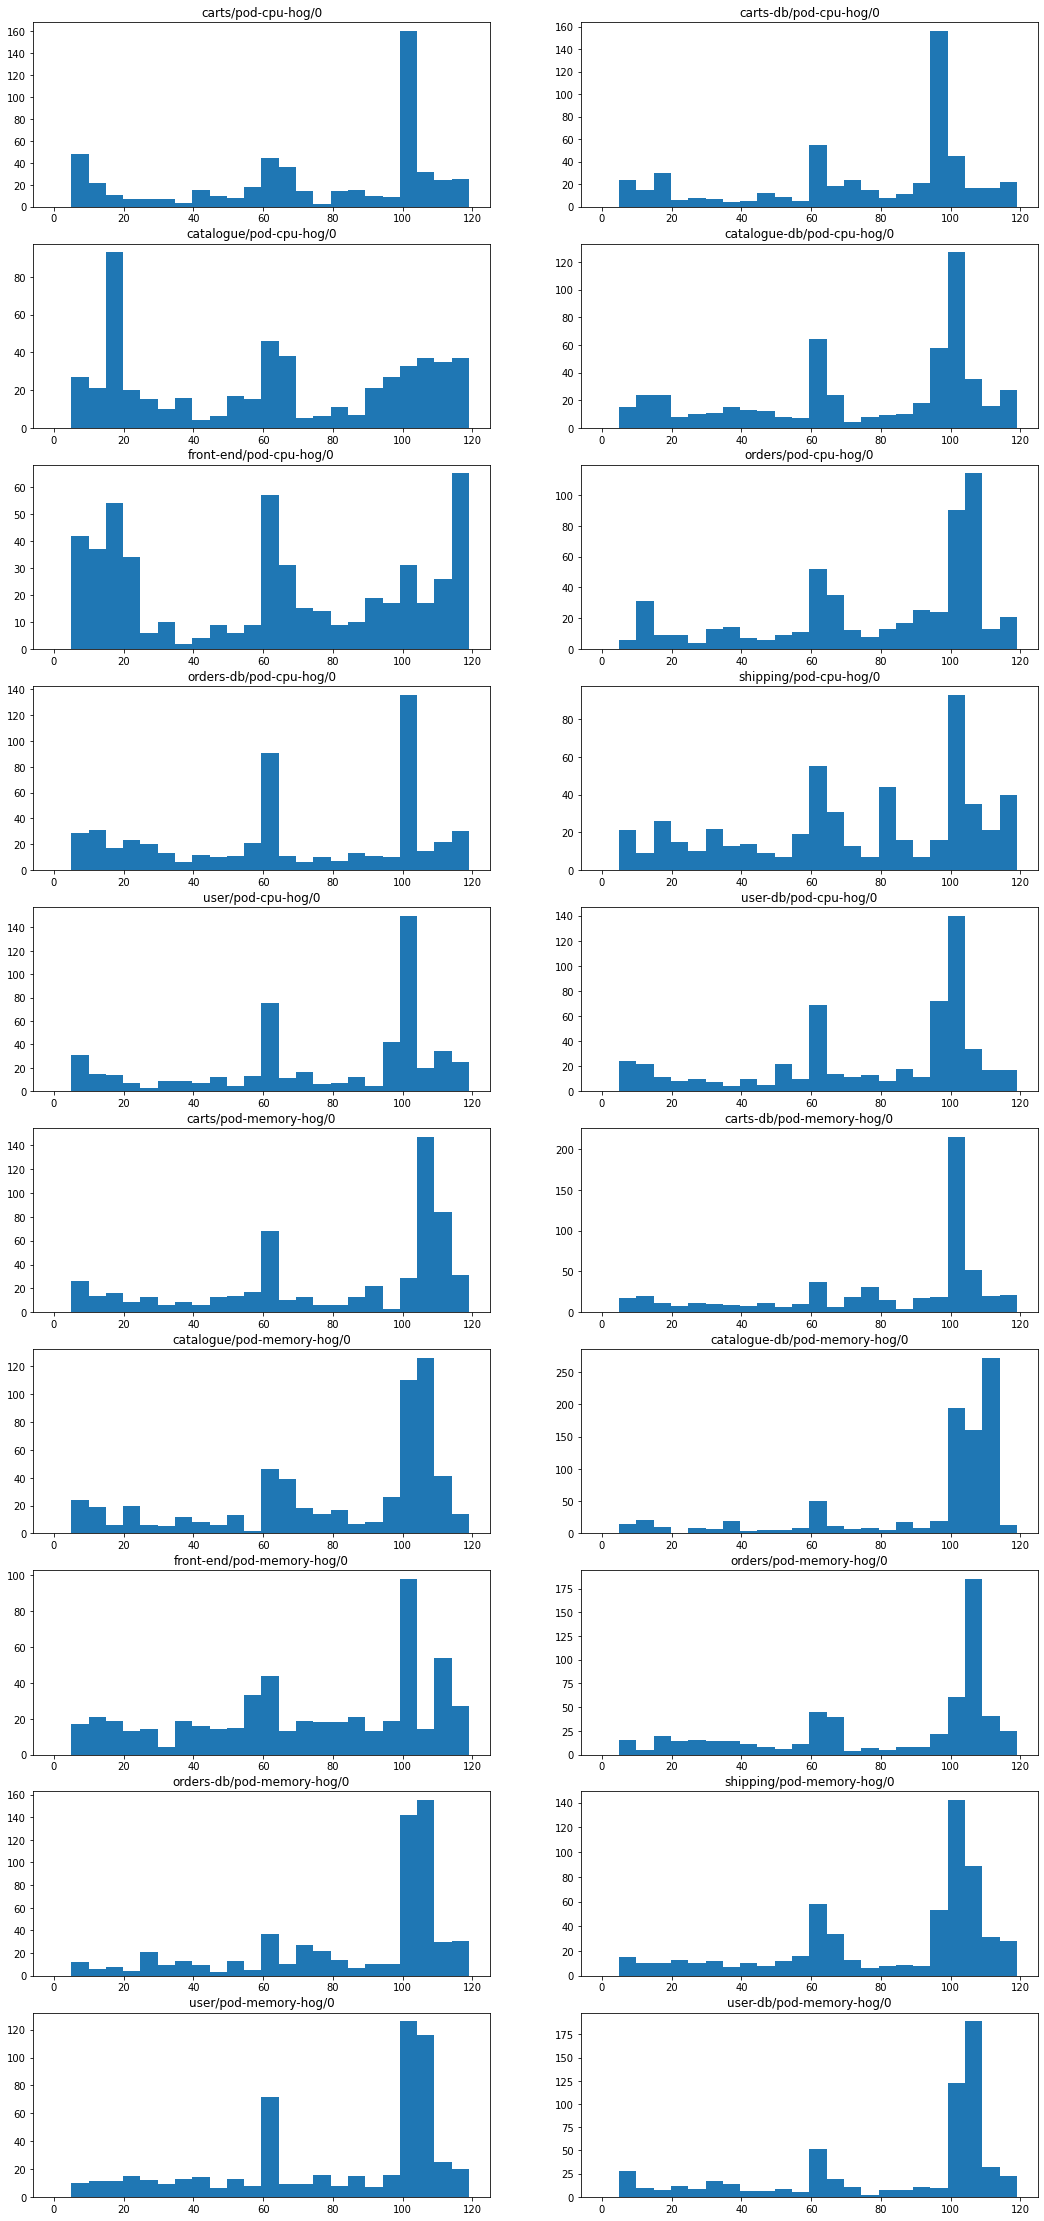

In [4]:
import warnings

from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

fig, axs = plt.subplots(math.ceil(len(records)/2), ncols=2)
fig.set_size_inches(18, 2*len(records))
for record, ax in zip(records, axs.flatten()):
    df = record.data_df

    def detect_anomaly(x) -> int:
        if np.all(x == x[0]) or np.all(np.isnan(x)):
            return -1
        # detect change start time
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            algo = rpt.Binseg(model='normal').fit(x)
        bkp = algo.predict(n_bkps=1)[0]
        return bkp

    bkps = np.apply_along_axis(detect_anomaly, 0, df.to_numpy())

    ax.set_title(record.chaos_case_full())
    ax.hist(bkps, range=(0, 119), bins=24)

In [8]:
from tsdr.outlierdetection.residual_integral import residual_integral_max
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

path_metrics_num_total = 0
for record in records:
    ok, path_metrics = groundtruth.check_tsdr_ground_truth_by_route(
        metrics=list(record.data_df.columns),
        chaos_type=record.chaos_type,
        chaos_comp=record.chaos_comp,
    )
    path_metrics_num_total += len(path_metrics)

    cols = []
    for col in path_metrics:
        ts = record.data_df[col].to_numpy()
        if np.all(ts == ts[0]):
            continue
        cols.append(col)

    fig, axs = plt.subplots(math.ceil(len(cols)/4), ncols=4)
    fig.set_size_inches(20, 1.5*len(cols))
    fig.suptitle(f"{record.chaos_case_full()}, metrics_total: {len(cols)}/{len(path_metrics)}")
    for col, ax in zip(cols, axs.flatten()):
        ts = record.data_df[col].to_numpy()

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            algo = rpt.Binseg(model='normal').fit(ts)
        bkp = algo.predict(n_bkps=1)[0]
        ax.axvline(bkp - 0.5, color='k', alpha=0.9, linestyle="--", linewidth=3)

        max_rss, max_rss_range = residual_integral_max(ts, bkp=bkp)

        ax.set_title(col + f"/rss=\n{max_rss:.1f}")
        ax.plot(ts)
        xrange = [t for (t, v) in max_rss_range]
        ax.plot(xrange, ts[xrange], 'o') 

        # prediction plots
        train_x, test_x = np.split(ts, [bkp])
        ols = OLS(train_x, add_constant(np.arange(1, train_x.size+1))).fit()
        test_pred = ols.predict(exog=add_constant(np.arange(train_x.size+1, ts.size+1)))
        pred_x = np.append(ols.predict(), test_pred)
        ax.plot(pred_x)

print("path metrics num total: ", path_metrics_num_total)